# ***Stochastic Inventory Uncapacitated Lot-Sizing Problem with Backlogging***

### READ FILE


In [27]:
import numpy as np
import pandas as pd

class ProductionData:
    def __init__(self, demand_forecast, setup_cost, production_cost, holding_cost, backlogging_cost, num_periods):
        self.demand_forecast = np.array(demand_forecast)
        self.setup_cost = np.array(setup_cost)
        self.production_cost = np.array(production_cost)
        self.holding_cost = np.array(holding_cost)
        self.backlogging_cost = np.array(backlogging_cost)
        self.num_periods = num_periods
    
    def __repr__(self):
        return (f"ProductionData(\n"
                f"  Demand Forecast: {self.demand_forecast}\n"
                f"  Setup Cost: {self.setup_cost}\n"
                f"  Production Cost: {self.production_cost}\n"
                f"  Holding Cost: {self.holding_cost}\n"
                f"  backlogging cost: {self.backlogging_cost}\n"
                f"  Number of Periods: {self.num_periods}\n")

def read_production_data(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Insert dummy period 0
    demand_forecast = np.insert(df["Demand Forecast"].to_numpy(), 0, 0)
    setup_cost = np.insert(df["Setup Cost"].to_numpy(), 0, 0)
    production_cost = np.insert(df["Production cost"].to_numpy(), 0, 0)
    holding_cost = np.insert(df["Holding cost"].to_numpy(), 0, 0)
    backlogging_cost = np.insert(df["Backlogging cost"].to_numpy(), 0, 0)
    
    num_periods = df.shape[0]
    
    return ProductionData(demand_forecast, setup_cost, production_cost, holding_cost, backlogging_cost, num_periods)

# Define file path and sheet names
file_path = "ULSP-instancesR.xlsx"
sheet_list = ["6-periods (1)", "6-periods (2)", "12-periods (1)", "12-periods (2)", 
              "24-periods (1)", "24-periods (2)", "52-periods (1)", "52-periods (2)", 
              "104-periods (1)", "104-periods (2)"]



In [33]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np

# DataFrame to store all results
results_df = pd.DataFrame(columns=["Sheet", "Period", "y", "x", "S", "b"])

# Process each sheet
for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")

    # Read data using the function
    data = read_production_data(file_path, sheet_name)

    T = data.num_periods
    print(f"Number of periods: {T}")

    # Create Gurobi model
    model = gp.Model("Uncapacitated Lot-Sizing Problem")

    # Decision variables
    y = model.addVars(T+1, vtype=GRB.BINARY, name="y")  
    x = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="x")  
    S = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="S")  
    b = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="b")  # Amount backlogged at the end of period t

    # Objective function
    model.setObjective(
        quicksum(data.setup_cost[t] * y[t] for t in range(1, T+1)) +
        quicksum(data.production_cost[t] * x[t] for t in range(1, T+1)) +
        quicksum(data.holding_cost[t] * S[t] for t in range(1, T+1)) +
        #quicksum(data.holding_cost[t] * b[t] for t in range(1, T+1)) +      # holding cost for backlog
        quicksum(data.backlogging_cost[t] * b[t] for t in range(1, T+1)),   # backlogging cost
        GRB.MINIMIZE
    )

    # Constraints
    model.addConstr(S[0] == 0, name="no_inventory0")
    model.addConstr(S[T] == 0, name="no_inventoryT")
    model.addConstr(b[0] == 0, name="no_backlogging0")
    model.addConstr(b[T] == 0, name="no_backloggingT")

    for t in range(1, T+1):
        model.addConstr(x[t] + S[t-1] - b[t-1] == data.demand_forecast[t] + S[t] - b[t], name=f"demand_satisfied_{t}")
        model.addConstr(x[t] <= (quicksum(data.demand_forecast[m] for m in range(t, T+1)) - b[t]) * y[t], name=f"setup_constraint_{t}")

    # Solve model
    model.optimize()

    # Check if the model found an optimal solution
    if model.status == GRB.OPTIMAL:
        print("\nOptimal solution found:")
        # Create a temporary DataFrame for the current sheet results
        sheet_results = pd.DataFrame(columns=["Sheet", "Period", "y", "x", "S", "b"])
        for t in range(1, T+1):
            # Store the results for the current sheet
            sheet_results = pd.concat([sheet_results, pd.DataFrame([{
                "Sheet": sheet_name,
                "Period": t,
                "y": y[t].X,
                "x": x[t].X,
                "S": S[t].X,
                "b": b[t].X
            }])], ignore_index=True)
        
        # Concatenate the results for all sheets
        results_df = pd.concat([results_df, sheet_results], ignore_index=True)

    else:
        print(f"No optimal solution found for sheet {sheet_name}.")

# Save results to a CSV file
results_df.to_csv("val_backlog_results.csv", index=False)
print("\nResults have been saved to 'optimization_results.csv'.")



Processing sheet: 6-periods (1)
Number of periods: 6
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 10 rows, 28 columns and 34 nonzeros
Model fingerprint: 0xf4937bef
Model has 6 quadratic constraints
Variable types: 21 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 2e+03]
  Objective range  [3e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 6e+02]
Presolve removed 4 rows and 7 columns
Presolve time: 0.00s
Presolved: 21 rows, 36 columns, 64 nonzeros
Presolved model has 10 SOS constraint(s)
Variable types: 25 continuous, 11 integer (11 binary)

Root relaxatio

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\1004644948.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{
C:\Users\irako\AppData\Local\Temp\ipykernel_10980\1004644948.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, sheet_results], ignore_index=True)



Solution count 2: 105079 146785 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.050790000000e+05, best bound 1.050790000000e+05, gap 0.0000%

Optimal solution found:

Processing sheet: 12-periods (1)
Number of periods: 12
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 16 rows, 52 columns and 64 nonzeros
Model fingerprint: 0xb68a7c4f
Model has 12 quadratic constraints
Variable types: 39 continuous, 13 integer (13 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 5e+03]
  Objective range  [1e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 9e+02]
Presolve removed 4 rows an

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\1004644948.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{



Optimal solution found:

Processing sheet: 12-periods (2)
Number of periods: 12
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 16 rows, 52 columns and 64 nonzeros
Model fingerprint: 0x2dc05f80
Model has 12 quadratic constraints
Variable types: 39 continuous, 13 integer (13 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 6e+03]
  Objective range  [2e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+01, 1e+03]
Presolve removed 4 rows and 7 columns
Presolve time: 0.00s
Presolved: 45 rows, 78 columns, 142 nonzeros
Presolved model has 22 SOS constraint(s)
Variable types: 55 continuous, 23 inte

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\1004644948.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{
C:\Users\irako\AppData\Local\Temp\ipykernel_10980\1004644948.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


Number of periods: 24
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 28 rows, 100 columns and 124 nonzeros
Model fingerprint: 0x6548acc6
Model has 24 quadratic constraints
Variable types: 75 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+04]
  Objective range  [2e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+01, 9e+02]
Presolve removed 4 rows and 7 columns
Presolve time: 0.00s
Presolved: 93 rows, 162 columns, 298 nonzeros
Presolved model has 46 SOS constraint(s)
Variable types: 115 continuous, 47 integer (47 binary)
Found heuristic solution: objective 495

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\1004644948.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


Cutting planes:
  Gomory: 7
  Implied bound: 2
  MIR: 9
  Flow cover: 17
  Flow path: 5
  Relax-and-lift: 9

Explored 1 nodes (87 simplex iterations) in 0.16 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 120671 120712 132845 ... 147500

Optimal solution found (tolerance 1.00e-04)
Best objective 1.206710000000e+05, best bound 1.206710000000e+05, gap 0.0000%

Optimal solution found:

Processing sheet: 52-periods (1)
Number of periods: 52
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 56 rows, 212 columns and 264 nonzeros
Model fingerprint: 0xfeb5a49e
Model has 52 quadratic constraints
Variable types: 159 continuous, 53 integer (53 binary)
Co

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\1004644948.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


     0     0 197572.195    0   17 212985.000 197572.195  7.24%     -    0s
H    0     0                    210604.00000 200888.736  4.61%     -    0s
     0     0 200888.736    0   25 210604.000 200888.736  4.61%     -    0s
     0     0 201298.786    0   25 210604.000 201298.786  4.42%     -    0s
H    0     0                    210387.00000 201298.786  4.32%     -    0s
     0     2 201298.786    0   25 210387.000 201298.786  4.32%     -    0s
H    5     7                    208320.00000 202561.459  2.76%   2.8    0s
*   52    34              13    206970.00000 203244.391  1.80%   2.5    0s
*   61    34              12    206778.00000 203244.391  1.71%   2.8    0s
*   85    26              11    205551.00000 203244.391  1.12%   2.7    0s
*   87    26              11    205070.00000 203244.391  0.89%   2.7    0s

Cutting planes:
  Gomory: 22
  Implied bound: 7
  MIR: 24
  Flow cover: 48
  Flow path: 16
  Relax-and-lift: 13

Explored 123 nodes (545 simplex iterations) in 0.21 seconds (

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\1004644948.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


     0     0 201394.261    0   16 203064.000 201394.261  0.82%     -    0s
     0     0 201394.261    0    7 203064.000 201394.261  0.82%     -    0s
     0     0 201767.479    0    7 203064.000 201767.479  0.64%     -    0s
     0     0 203020.997    0    2 203064.000 203020.997  0.02%     -    0s

Cutting planes:
  Gomory: 13
  Implied bound: 1
  MIR: 4
  Flow cover: 22
  Flow path: 4
  Relax-and-lift: 8

Explored 1 nodes (356 simplex iterations) in 0.16 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 9: 203064 206469 208955 ... 293034

Optimal solution found (tolerance 1.00e-04)
Best objective 2.030640000000e+05, best bound 2.030640000000e+05, gap 0.0000%

Optimal solution found:

Processing sheet: 104-periods (1)
Number of periods: 104
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\1004644948.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


  Objective range  [1e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 1e+03]
Presolve removed 6 rows and 10 columns
Presolve time: 0.00s
Presolved: 411 rows, 719 columns, 1331 nonzeros
Presolved model has 206 SOS constraint(s)
Variable types: 513 continuous, 206 integer (206 binary)
Found heuristic solution: objective 6359772.0141

Root relaxation: objective 2.258591e+05, 241 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 225859.074    0   81 6359772.01 225859.074  96.4%     -    0s
H    0     0                    6203560.9999 225859.074  96.4%     -    0s
H    0     0                    420978.00000 225859.074  46.3%     -    0s
H    0     0                    418475.00000 225859.074  46.0%     -    0s
H    0     0                    417365.00000 225859.074  45.9%     -    0s
H    0     0              

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\1004644948.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


H    0     0                    1806622.0000 423281.199  76.6%     -    0s
H    0     0                    1762028.0000 423281.199  76.0%     -    0s
H    0     0                    1718318.0000 423281.199  75.4%     -    0s
H    0     0                    1703189.0000 423281.199  75.1%     -    0s
H    0     0                    1021246.0000 423281.199  58.6%     -    0s
H    0     0                    987996.00000 542231.604  45.1%     -    0s
     0     0 542231.604    0   61 987996.000 542231.604  45.1%     -    0s
H    0     0                    917198.00000 545301.781  40.5%     -    0s
     0     0 546633.622    0   62 917198.000 546633.622  40.4%     -    0s
H    0     0                    895437.00000 602639.072  32.7%     -    0s
H    0     0                    849441.00000 602639.072  29.1%     -    0s
     0     0 603903.267    0   70 849441.000 603903.267  28.9%     -    0s
     0     0 604097.500    0   70 849441.000 604097.500  28.9%     -    0s
     0     2 604097.500  

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\1004644948.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


## 10.1 Pattern Observation in MILP

Large backlogs are observed at the start of most of the instancs in the MILP solution. This is expected as the model's strategy to minimize setup and production costs. Since the backlogging costs are significantly lower that other costs, the model delays production to avoid high setup costs in the early periods, leading to an accumulation of backlog. As production ramps up in later periods, the backlog decreases. This behavior reflects the natural trade-offs between setup, production, and backlog costs.

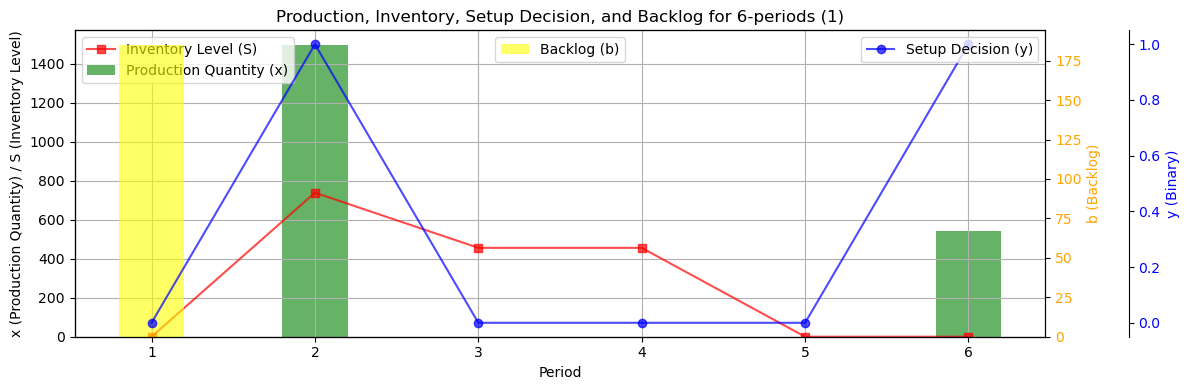

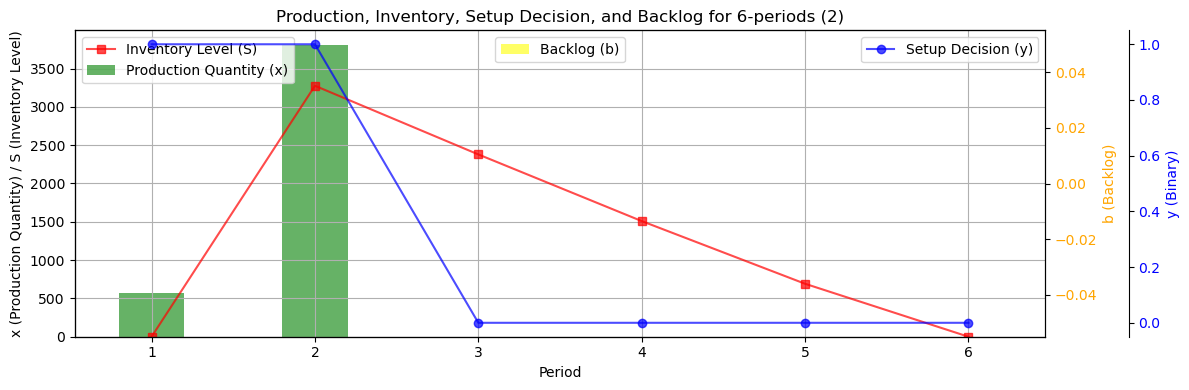

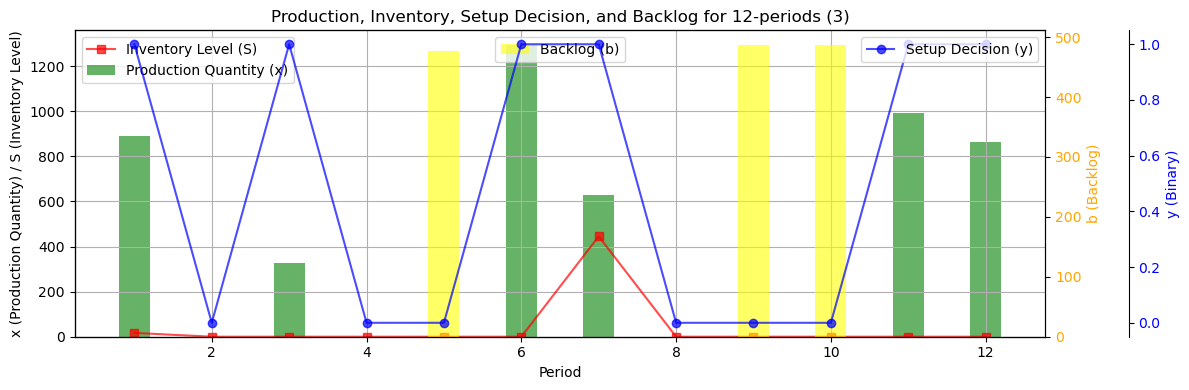

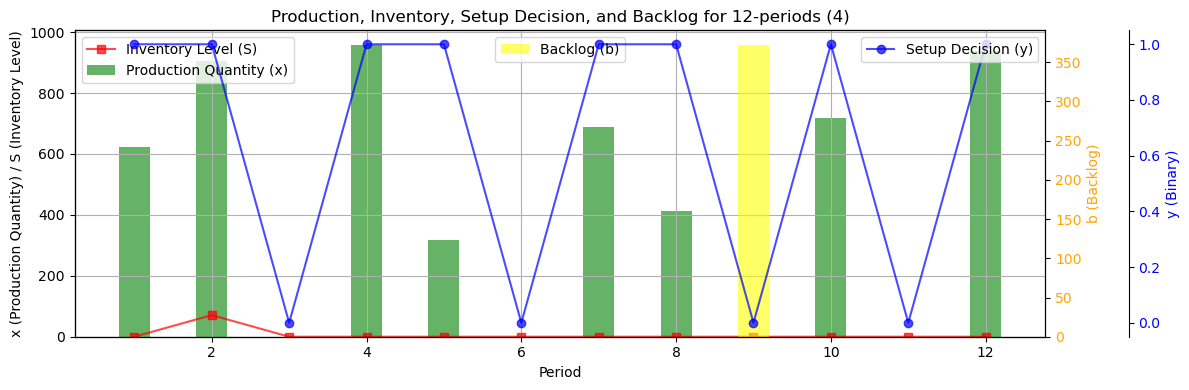

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the all_results CSV file into a DataFrame
results_df = pd.read_csv("Val_backlog_results.csv")

# Define function to plot data
def plot_data(data, sheet_name):
    fig, ax1 = plt.subplots(figsize=(12, 4))
    
    # Plot production quantity (x) as a bar chart
    ax1.bar(data['Period'], data['x'], color='g', width=0.4, label='Production Quantity (x)', alpha=0.6)
    
    # Plot inventory level (S) as a red line
    ax1.plot(data['Period'], data['S'], marker='s', linestyle='-', color='r', label='Inventory Level (S)', alpha=0.7)
    
    ax1.set_xlabel('Period')
    ax1.set_ylabel('x (Production Quantity) / S (Inventory Level)')
    ax1.tick_params(axis='y')

    # Create a second y-axis for backlog (b)
    ax2 = ax1.twinx()
    
    # Plot backlog (b) as a yellow block (bar)
    ax2.bar(data['Period'], data['b'], color='yellow', label='Backlog (b)', alpha=0.6, width=0.4)
    ax2.set_ylabel('b (Backlog)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Create a third y-axis for setup decision (y)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Shift the third axis to avoid overlap
    
    # Plot setup decision (y) as a blue line
    ax3.plot(data['Period'], data['y'], marker='o', linestyle='-', color='b', label='Setup Decision (y)', alpha=0.7)
    ax3.set_ylabel('y (Binary)', color='b')
    ax3.tick_params(axis='y', labelcolor='b')

    plt.title(f'Production, Inventory, Setup Decision, and Backlog for {sheet_name}')
    ax1.grid(True)
    
    # Adding legends for all three y-axes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper center')
    ax3.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Split the CSV into instances
sheet_ranges = [
    ("6-periods (1)", 0, 6),
    ("6-periods (2)", 6, 12),
    ("12-periods (3)", 12, 24),
    ("12-periods (4)", 24, 36)
]

for sheet_name, start_row, end_row in sheet_ranges:
    sheet_data = results_df.iloc[start_row:end_row]
    plot_data(sheet_data, sheet_name)


## 10.2 Zangwill

In [23]:
import numpy as np

def si_ulspwb(demand, setup_costs, holding_costs, backlogging_costs, production_costs, num_periods):
    T = num_periods  # Number of periods
    C = np.full((T+1, T+1), float('inf'))  # Cost array, initialized to infinity
    C[0, 0] = 0  # Base case: No cost at period 0 with zero inventory and backlog
    order_periods = np.full((T+1, T+1), -1)  # To track order placements (start periods)
    
    # For each period t
    for t in range(1, T+1):
        # Try all possible last order periods j to find which j to produce to meet the demand
        for j in range(1, t+1):  # j is the starting period for a production order
            # Calculate costs when producing in period j for periods j through t
            
            # Setup cost for production in period j
            setup_cost = setup_costs[j-1]
            
            # Production cost for all demand from j to t
            production_cost = production_costs[j-1] * sum(demand[k] for k in range(j-1, t))
            
            # Holding costs for demands of periods k (j < k ≤ t)
            holding_cost = sum(
                holding_costs[k] * sum(demand[m] for m in range(k, t))
                for k in range(j-1, t-1)
            )
            
            # Backlog cost for all periods from j to t
            backlogging_cost = sum(backlogging_costs[k] * max(0, sum(demand[m] for m in range(k, t)) - sum(demand[k] for k in range(j-1, k)))
                               for k in range(j-1, t))
            
            # Total cost for this option
            cost = setup_cost + production_cost + holding_cost + backlogging_cost
            
            # Add cost of optimal solution up to period j-1 with the same inventory and backlog conditions
            total_cost = C[j-1, 0] + cost  # C[j-1, 0] stores optimal cost up to period j-1
            
            # Update if this solution is better (minimum cost for period t)
            if total_cost < C[t, 0]:
                C[t, 0] = total_cost
                order_periods[t, 0] = j
    
    # Backtrack to find the optimal order schedule
    t = T
    orders = []
    while t > 0:
        j = order_periods[t, 0]
        order_quantity = sum(demand[k] for k in range(j-1, t))
        orders.append((j, order_quantity))
        t = j-1
    
    return list(reversed(orders)), C[T, 0]

# Example usage
for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")

    # Read the Excel file from the specific sheet
    data = read_production_data(file_path, sheet_name)
    
    optimal_orders, min_cost = si_ulspwb(
        data.demand_forecast, 
        data.setup_cost, 
        data.holding_cost, 
        data.backlogging_cost, 
        data.production_cost, 
        data.num_periods
    )
    print("Optimal order schedule:", optimal_orders)
    print("Minimum total cost:", min_cost)



Processing sheet: 6-periods (1)
Optimal order schedule: [(1, 1497)]
Minimum total cost: 34279.0

Processing sheet: 6-periods (2)
Optimal order schedule: [(1, 3690)]
Minimum total cost: 68631.0

Processing sheet: 12-periods (1)
Optimal order schedule: [(1, 1217), (5, 0), (6, 477), (7, 817), (8, 627), (10, 487), (11, 0), (12, 506)]
Minimum total cost: 57333.0

Processing sheet: 12-periods (2)
Optimal order schedule: [(1, 623), (3, 835), (4, 71), (5, 958), (6, 319), (7, 0), (8, 689), (9, 414), (10, 372), (11, 346), (12, 0)]
Minimum total cost: 55152.0

Processing sheet: 24-periods (1)
Optimal order schedule: [(1, 660), (3, 837), (4, 164), (5, 0), (6, 857), (7, 117), (8, 73), (9, 0), (10, 100), (11, 454), (12, 924), (13, 496), (14, 703), (15, 469), (16, 706), (17, 907), (18, 321), (19, 0), (20, 192), (21, 0), (23, 883), (24, 783)]
Minimum total cost: 115655.0

Processing sheet: 24-periods (2)
Optimal order schedule: [(1, 1067), (4, 1366), (6, 1185), (10, 791), (13, 414), (14, 403), (15, 6